In [1]:
import pandas as pd
import numpy as np
import os
import h5py
from sklearn import linear_model
import matplotlib.pyplot as plt

import deepdish as dd
import string
try:
    os.chdir('/data/MoL_clean/scripts')
except:
    pass
import util
# util has some variables in them
# import GLM_helper as gh


import scipy.stats as stats
import glob

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sentence_transformers import SentenceTransformer
from scipy.stats import ttest_1samp

from scipy import stats, linalg
import warnings
from joblib import Parallel, delayed
import multiprocessing
from sentence_transformers import CrossEncoder
import seaborn as sns
warnings.filterwarnings('ignore')

sub2subj = {"sub-01":"subj001", "sub-02":"subj002","sub-03":"subj003","sub-04":"subj005",
              "sub-05":"subj006", "sub-06":"subj007", "sub-07":"subj008", "sub-08":"subj009", 
           "sub-09":"subj010","sub-10":"subj011","sub-11":"subj013", "sub-12":"subj014", 
            "sub-13":"subj017", "sub-14":"subj018", "sub-15":"subj019", "sub-16":"subj020",
           "sub-17":"subj021", "sub-18":"subj022", "sub-19":"subj023", "sub-20":"subj024",'sub-21':'subj025',
           'sub-22':'subj026','sub-23':'subj027','sub-24':'subj029','sub-25':'subj031'}
ses2w = {"ses-01":"W2", "ses-02":"W4D1", "ses-03":"W4D2"}


nv = 40962

subjects = ['sub-%.2d'%s for s in range(1,26)]
sessions = ['ses-%.2d'%s for s in range(1,3)]
runs = ['run-%.2d'%s for s in range(1,3)]
TR = 1.5
nTRs = {'Item':302, 'Loci':302, 'Encode':355}

model = CrossEncoder('cross-encoder/stsb-roberta-large')

def getSentenceSimilarity(sentence1, sentence2):
    return model.predict([(sentence1, sentence2)])[0]
nTRs_w4d2 = {'Item': 156, 'Loci': 156, 'Encode': 182}
SL_lh = list(dd.io.load('SLlist_verydense.lh.h5').values())
SL_rh = list(dd.io.load('SLlist_verydense.rh.h5').values())
ag = list(dd.io.load('ROIs/Ang_verts.h5').values())
pmc = list(dd.io.load('ROIs/PMC_verts.h5').values())
mPFC = list(dd.io.load('ROIs/mPFC_verts.h5').values())
ROIs = {'ag':ag, 'pmc':pmc, 'mpfc':mPFC}
SLlist = {'L':SL_lh, "R": SL_rh}
nSL_L = len(SLlist['L'])

In [ ]:
# visualize ROI 
for roi in ROIs:
    empty_brain_lh = np.zeros((nv))
    empty_brain_rh = np.zeros((nv))
    roi_illustration_lh = ROIs[roi][0]
    roi_illustration_rh = ROIs[roi][1]
    empty_brain_lh[roi_illustration_lh] = 1
    empty_brain_rh[roi_illustration_rh] = 1
    np.savetxt('../outputs/%s_illustration_lh.txt'%roi, empty_brain_lh)
    np.savetxt('../outputs/%s_illustration_rh.txt'%roi, empty_brain_rh)


In [2]:
def remove_xs(string_list):
    return [s for s in string_list if s!='x']


def add_numbers_to_duplicates(string_list):
    count = {}
    new_list = []
    
    for item in string_list:
        if item in count and item!='x':
            count[item] += 1
            new_item = f"{item} {count[item]}"
        else:
            count[item] = 1
            new_item = item
        
        new_list.append(new_item.lower())
        
    return new_list


def partial_corr(C, desired_i= None, desired_j=None):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Desired_i, desired_j: int
        If only wants to calculate the partial correlation between desired_i and desired_j, set them to be the index of the variables

    
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C
    """
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    if desired_i is not None and desired_j is not None:
        P_corr[desired_i, desired_j] = 1
        P_corr[desired_j, desired_i] = 1
        idx = np.ones(p, dtype=np.bool)
        idx[desired_i] = False
        idx[desired_j] = False
        beta_i = linalg.lstsq(C[:, idx], C[:, desired_j])[0]
        beta_j = linalg.lstsq(C[:, idx], C[:, desired_i])[0]

        res_j = C[:, desired_j] - C[:, idx].dot( beta_i)
        res_i = C[:, desired_i] - C[:, idx].dot(beta_j)

        corr = stats.pearsonr(res_i, res_j)[0]
        P_corr[desired_i, desired_j] = corr
        P_corr[desired_j, desired_i] = corr
        P_corr = corr
    else:
        for i in range(p):
            P_corr[i, i] = 1
            for j in range(i+1, p):
                idx = np.ones(p, dtype=np.bool)
                idx[i] = False
                idx[j] = False
                beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
                beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

                res_j = C[:, j] - C[:, idx].dot( beta_i)
                res_i = C[:, i] - C[:, idx].dot(beta_j)
                
                corr = stats.pearsonr(res_i, res_j)[0]
                P_corr[i, j] = corr
                P_corr[j, i] = corr
            
    return P_corr

def SLtoVox(D, SLlist, nv, zeronan=True):
    # D is dict of L, R, with N x arbitrary dims
    # SLlist is dict of L, R list of length N, with vertices for each SL

    Dvox = dict()
    Dcount = dict()
    for hem in ['L', 'R']:
        Dvox[hem] = np.zeros((nv,)+ D[hem].shape[1:])
        Dcount[hem] = np.zeros((nv,)+(1,)*len(D[hem].shape[1:]))
        for i in range(len(SLlist[hem])):
            Dvox[hem][SLlist[hem][i]] += D[hem][i]
            Dcount[hem][SLlist[hem][i]] += 1

        Dcount[hem][Dcount[hem] == 0] = np.nan
        Dvox[hem] = Dvox[hem] / Dcount[hem]

        if zeronan:
            Dvox[hem][np.isnan(Dvox[hem])] = 0

    return Dvox

In [3]:
def get_beta_dicts(sub,ses,hippo=False):
    task = 'Item'
    # load item 
    item_filenames = sorted(glob.glob(f'../behavioral/{sub2subj[sub]}/{ses2w[ses]}/*{task.lower()}*.csv'))
    item_words_lists = [[w for w in pd.read_csv(item_filenames[0])['Word'] if w is not np.nan],[w for w in pd.read_csv(item_filenames[1])['Word'] if w is not np.nan]]
    item_beta_dict = {'lh':{w:[] for w in item_words_lists[0]}, 'rh':{w:[] for w in item_words_lists[0]},'anterior_hipp':{w:[] for w in item_words_lists[0]},'posterior_hipp':{w:[] for w in item_words_lists[0]},
                    'hippo':{w:[] for w in item_words_lists[0]},'posterior_hipp_group':{w:[] for w in item_words_lists[0]},
                    'anterior_hipp_group':{w:[] for w in item_words_lists[0]},'hippo_group':{w:[] for w in item_words_lists[0]}}
    task = 'Loci'
    # load loci lists, with loci names in two lists. Create a dictionary accordingly taking the union of the two lists
    loci_lists = [add_numbers_to_duplicates(list(pd.read_excel('../sheets/%s_recallperformance.xlsx'%sub2subj[sub], sheet_name='%sloci1'%ses2w[ses].lower())['spoken_loci'])),
                        add_numbers_to_duplicates(list(pd.read_excel('../sheets/%s_recallperformance.xlsx'%sub2subj[sub], sheet_name='%sloci2'%ses2w[ses].lower())['spoken_loci'])),]
    loci_beta_dict = {"lh":{l:[] for l in list(set(loci_lists[0]+loci_lists[1]))}, "rh":{l:[] for l in list(set(loci_lists[0]+loci_lists[1]))},"anterior_hipp":{l:[] for l in list(set(loci_lists[0]+loci_lists[1]))},"posterior_hipp":{l:[] for l in list(set(loci_lists[0]+loci_lists[1]))},
                    "hippo":{l:[] for l in list(set(loci_lists[0]+loci_lists[1]))},"posterior_hipp_group":{l:[] for l in list(set(loci_lists[0]+loci_lists[1]))},
                    "anterior_hipp_group":{l:[] for l in list(set(loci_lists[0]+loci_lists[1]))},"hippo_group":{l:[] for l in list(set(loci_lists[0]+loci_lists[1]))}}
    
    # create dictionary of locus and item for each of the two runs
    for hem in ['lh','rh','anterior_hipp','posterior_hipp','hippo', 'anterior_hipp_group','posterior_hipp_group','hippo_group']:
        run = 'run-01'
        loci_fmri = np.loadtxt('../outputs/betas/%s/%s_%s_%s_%s_beta.txt'%(task.lower(),sub,ses,run,hem))
        for i, l in enumerate(loci_lists[0]):
            loci_beta_dict[hem][l].append(loci_fmri[:,i])
        run = 'run-02'
        loci_fmri = np.loadtxt('../outputs/betas/%s/%s_%s_%s_%s_beta.txt'%(task.lower(),sub,ses,run,hem))
        for i, l in enumerate(loci_lists[1]):
            loci_beta_dict[hem][l].append(loci_fmri[:,i])
    # average locus rep if spoken in both runs
        for l in loci_beta_dict[hem]:
            if len(loci_beta_dict[hem][l]) == 2:
                loci_beta_dict[hem][l] = np.mean(loci_beta_dict[hem][l],axis=0)
            else:
                loci_beta_dict[hem][l] = loci_beta_dict[hem][l][0]
    
    for hem in ['lh','rh','anterior_hipp','posterior_hipp','hippo', 'anterior_hipp_group','posterior_hipp_group','hippo_group']: 
        run = 'run-01'
        task = 'Item'
        item_fmri = np.loadtxt('../outputs/betas/%s/%s_%s_%s_%s_beta.txt'%(task.lower(),sub,ses,run,hem))
        for i, w in enumerate(item_words_lists[0]):
            item_beta_dict[hem][w].append(item_fmri[:,i])
        run = 'run-02'
        item_fmri = np.loadtxt('../outputs/betas/%s/%s_%s_%s_%s_beta.txt'%(task.lower(),sub,ses,run,hem))
        for i, w in enumerate(item_words_lists[1]):
            item_beta_dict[hem][w].append(item_fmri[:,i])

        for w in item_beta_dict[hem]:
            item_beta_dict[hem][w] = np.mean(item_beta_dict[hem][w],axis=0)

    retrieve_beta_dict = {'lh':{},'rh':{},'anterior_hipp':{},'posterior_hipp':{},'hippo':{}, 'anterior_hipp_group':{},'posterior_hipp_group':{},'hippo_group':{}}
    encode_beta_dict = {'lh':{},'rh':{},'anterior_hipp':{},'posterior_hipp':{},'hippo':{}, 'anterior_hipp_group':{},'posterior_hipp_group':{},'hippo_group':{}}
    run = 'run-01'
    for hem in ['lh','rh','anterior_hipp','posterior_hipp','hippo', 'anterior_hipp_group','posterior_hipp_group','hippo_group']:
        recall_sheet = pd.read_excel('../sheets/%s_recallperformance.xlsx'%sub2subj[sub], sheet_name=ses2w[ses].lower())
        recall_sheet['retrieval'] = recall_sheet['retrieval'].apply(lambda x: x.split(' ')[0])
        recall_fmri = np.loadtxt('../outputs/betas/%s/%s_%s_%s_%s_beta.txt'%('retrieve',sub,ses,run,hem))
        encode_fmri = np.loadtxt('../outputs/betas/%s/%s_%s_%s_%s_beta.txt'%('encode',sub,ses,run,hem))
        if ses != 'ses-03':
            encode_pairs = [recall_sheet['loci'][r]+'-'+recall_sheet['encode'][r] for r in range(len(recall_sheet))]
        else:
            encode_pairs = [recall_sheet['loci'][r]+'-'+recall_sheet['encode'][r] for r in range(len(recall_sheet))]
        valid_encode_pairs = [p for p in encode_pairs if p[0]!='x']
        for r, pair in enumerate(valid_encode_pairs):
            encode_beta_dict[hem][pair.lower()] = encode_fmri[:,r]
        ret_idx = 0
        for r in range(len(recall_sheet)):
            if recall_sheet['spoken_loci'][r]!='x':
                retrieve_beta_dict[hem][(recall_sheet['spoken_loci'][r]+'-'+recall_sheet['retrieval'][r]).lower()] = recall_fmri[:,ret_idx]
                ret_idx+=1
    return loci_beta_dict, item_beta_dict, encode_beta_dict, retrieve_beta_dict

def get_residuals(C, dv):
    """
    Returns the residuals of the dv(th) column of matrix C, accounting for all variances explained by other columns
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    
    Returns
    -------
    res : array-like, shape (n,)
        Residual of dv
    """
    C = np.asarray(C)
    p = C.shape[1]
    idx = np.ones(p, dtype=np.bool)
    idx[dv] = False
    beta = linalg.lstsq(C[:, idx], C[:, dv])[0]

    res = C[:, dv] - C[:, idx].dot(beta)
            
    return res


def get_residual(target, var1, var2):
    # Create a 2D array for the independent variables
    X = np.column_stack((var1, var2))
    
    # Fit a linear regression model with the independent variables
    model = LinearRegression()
    model.fit(X, target)
    
    # Get the predicted values for the target variable based on the model
    predicted = model.predict(X)
    
    # Calculate the residuals by subtracting the predicted values from the original target values
    residuals = target - predicted
    
    return residuals

def calculate_weights(x, y, z, A):
    """
    Calculate the weights of variables x, y, z in predicting each timepoint of matrix A.

    Parameters:
    x, y, z: Arrays of shape (nv,) representing the variables in each vertices in the ROI.
    A: Matrix of shape (nv, nTR) where each column is a timepoint.

    Returns:
    weights: A matrix of shape (nTR, 3) containing the weights for each variable for each timepoint.
    """

    # Combine x, y, z into a single matrix
    predictors = np.column_stack((x, y, z))
    try:
        num_TRs = A.shape[1]
            # Initialize an array to store weights
        weights = np.zeros((num_TRs, 3))

        # Loop over each timepoint
        for i in range(num_TRs):
            # Create a linear regression model
            model = LinearRegression()

            # Fit the model
            model.fit(predictors, A[:, i])

            # Store the weights
            weights[i, :] = model.coef_
    except:
        num_TRs = 1
        model = LinearRegression()
        model.fit(predictors, A)
        weights = model.coef_
    

    return weights

In [4]:
def get_diag_diff_perm(corrmat, nPerm=1000):
    '''
    return the (diagonal mean - off-diagonal) mean in a correlation matrix, including the all the means 
    if the correlation matrix is randomly shuffled

    Parameters
    ----------
    corrmat : array-like, shape (n_roi, n, n)
        Array with the different variables. 
        n_roi: number of rois
        n: the dimension of the correlation matrix
    nPerm: int, number of permutations

    Returns
    -------
    diag_diff : array-like, shape (nPerm+1,)
        Residual of dv
    '''
    diag_diff = np.zeros((corrmat.shape[0], nPerm+1))
    for i in range(corrmat.shape[0]):  
        np.random.seed(i)     
        corr_i = corrmat[i, :, :].copy()     
        corr_perm = corr_i[np.ix_(np.arange(1,corr_i.shape[1]), np.arange(1,corr_i.shape[1]))].copy()
        np.random.seed(0)
        for p in range(nPerm+1):
            diag_diff[i, p] = corr_perm[np.eye(corr_perm.shape[0],dtype=bool)].mean() - corr_perm[~np.eye(corr_perm.shape[0],dtype=bool)].mean()
            corr_perm = corr_perm[np.random.permutation(corr_perm.shape[0]), :].copy()
    return diag_diff

In [ ]:
story_matrix = pd.read_csv('../outputs/story_matrix_withHipp.csv')
l, i, e, r = get_beta_dicts('sub-01','ses-03')
pairs_gt = list(r['lh'].keys()) # ground truth pairs - correct pairs


In [6]:
story_matrix

,encode_pair,retrieve_pair,story,story_deviation,story_deviation_locus,story_deviation_item,speak_duration,sub,ses,e_i_sim_ag,...,r_i_sim_ag,r_i_sim_pmc,r_i_sim_mpfc,r_l_sim_ag,r_l_sim_pmc,r_l_sim_mpfc,e_r_sim_hipp,r_i_sim_hipp,r_l_sim_hipp,correct
0,windowsill-umbrella,windowsill-umbrella,So I walked into the living room and I look ou...,0.589790,0.500293,0.576973,26,sub-01,ses-01,-0.010402,...,-0.162301,0.001509,-0.003457,-0.205133,-0.043765,-0.032952,0.068549,-0.000793,0.044832,True
1,foot rest-hummingbird,foot rest-hummingbird,"And so I go to take a seat, but I don't see an...",0.358303,0.293401,0.281076,16,sub-01,ses-01,0.104820,...,-0.065832,-0.094907,0.044857,-0.097953,-0.065075,0.052370,0.044466,0.022493,0.020275,True
2,mirror-platypus,mirror-platypus,And I stand up and I look to the mirror to see...,0.659586,0.207227,0.570584,12,sub-01,ses-01,0.058669,...,0.080552,-0.090249,-0.050460,-0.155854,0.008327,0.045563,0.042816,-0.025540,-0.031559,True
3,candy jar-baby,candy jar-baby,"And so after that, I hear a noise. I turn arou...",0.479417,0.301244,0.400634,11,sub-01,ses-01,-0.000191,...,-0.166472,-0.003356,0.006915,0.031329,0.063560,0.045369,-0.038803,0.004411,-0.036658,True
4,couch-waterfall,couch-waterfall,"And then I see on the couch that like, water s...",0.456719,0.388446,0.458091,21,sub-01,ses-01,0.131011,...,0.014994,0.044503,0.076732,0.169186,-0.022514,0.248736,-0.012398,0.049084,-0.014749,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,well-baby,well-baby,The next locust is the old well. And the word ...,0.281151,0.221892,0.261991,21,sub-25,ses-03,0.153950,...,0.183965,0.173477,0.220921,-0.124561,-0.013237,0.143100,-0.009431,0.039095,-0.031169,True
2376,cart-ketchup,cart-ketchup,The next locus is the cart. And I imagine just...,0.564046,0.405813,0.528202,16,sub-25,ses-03,0.002326,...,0.004046,0.057270,0.102943,-0.006457,0.032888,-0.044648,0.046042,0.058668,-0.059247,True
2377,water cooler-passport,water cooler-passport,The next locus is the water cooler. And I imag...,0.407322,0.374591,0.352431,21,sub-25,ses-03,-0.185555,...,0.034639,0.006498,0.078831,0.014852,0.012691,0.042862,0.022856,-0.000761,0.017643,True
2378,fish tank-treadmill,fish tank-treadmill,The next locus is the fish tank. And the word ...,0.619993,0.580248,0.602058,20,sub-25,ses-03,0.037266,...,-0.371092,-0.082030,-0.129282,0.132717,-0.078529,0.161438,0.022688,-0.001842,-0.002128,True


In [ ]:
# obtain the encoding, retrieval residual representation for each pair, for each region, for all subjects
pair_residual_dict_ret = {pair:{'lh':[],'rh':[],'hippo':[],'posterior_hipp':[],'anterior_hipp':[],'hippo':[], 'anterior_hipp_group':[],'posterior_hipp_group':[],'hippo_group':[]} for pair in pairs_gt}
pair_residual_dict_enc = {pair:{'lh':[],'rh':[],'hippo':[],'posterior_hipp':[],'anterior_hipp':[],'hippo':[], 'anterior_hipp_group':[],'posterior_hipp_group':[],'hippo_group':[]} for pair in pairs_gt}
pair_dict_ret = {pair:{'lh':[],'rh':[],'hippo':[],'posterior_hipp':[],'anterior_hipp':[],'hippo':[], 'anterior_hipp_group':[],'posterior_hipp_group':[],'hippo_group':[]} for pair in pairs_gt}
pair_dict_enc = {pair:{'lh':[],'rh':[],'hippo':[],'posterior_hipp':[],'anterior_hipp':[],'hippo':[], 'anterior_hipp_group':[],'posterior_hipp_group':[],'hippo_group':[]} for pair in pairs_gt}
ses = 'ses-03'
ret_story_dict = {pair:[] for pair in pairs_gt}
for sub in subjects:
    print(sub)
    loci_beta_dict, item_beta_dict, encode_beta_dict, retrieve_beta_dict = get_beta_dicts(sub,ses)
    pairs_retrieved = list(retrieve_beta_dict['lh'].keys()) # pairs retrieved by the participants

    sub_ret_residual_dict = {'lh':{},'rh':{},'hippo':{},'posterior_hipp':{},'anterior_hipp':{},'hippo':{},'posterior_hipp_group':{},'anterior_hipp_group':{},'hippo_group':{}}
    sub_ret_dict = {'lh':{},'rh':{},'hippo':{},'posterior_hipp':{},'anterior_hipp':{},'hippo':{},'posterior_hipp_group':{},'anterior_hipp_group':{},'hippo_group':{}}
    sub_enc_reisdual_dict = {'lh':{},'rh':{},'hippo':{},'posterior_hipp':{},'anterior_hipp':{},'hippo':{},'posterior_hipp_group':{},'anterior_hipp_group':{},'hippo_group':{}}
    sub_enc_dict = {'lh':{},'rh':{},'hippo':{},'posterior_hipp':{},'anterior_hipp':{},'hippo':{},'posterior_hipp_group':{},'anterior_hipp_group':{},'hippo_group':{}}
    story_matrix_s3 = story_matrix[story_matrix['ses']=='ses-03']
    story_matrix_s3_sub= story_matrix_s3[story_matrix_s3['sub']==sub]

    for pair in pairs_gt:
        if pair in pairs_retrieved:
            ret_story_dict[pair].append(story_matrix_s3_sub[story_matrix_s3_sub['retrieve_pair']==pair]['story'].values[0])
            for hem in ['lh','rh']:
                retrieve_rep = retrieve_beta_dict[hem][pair]
                item_rep = item_beta_dict[hem][pair.split('-')[1]]
                locus_rep = loci_beta_dict[hem][pair.split('-')[0]]
                encode_rep = encode_beta_dict[hem][pair]
                ret_residual_rep = get_residual(retrieve_rep, item_rep, locus_rep)
                enc_residual_rep = get_residual(encode_rep, item_rep, locus_rep)
                sub_ret_residual_dict[hem][pair] = ret_residual_rep
                sub_enc_reisdual_dict[hem][pair] = enc_residual_rep

                sub_ret_dict[hem][pair] = retrieve_rep
                sub_enc_dict[hem][pair] = encode_rep

                
                pair_residual_dict_ret[pair][hem].append(sub_ret_residual_dict[hem][pair])
                pair_residual_dict_enc[pair][hem].append(sub_enc_reisdual_dict[hem][pair])
                pair_dict_ret[pair][hem].append(sub_ret_dict[hem][pair])
                pair_dict_enc[pair][hem].append(sub_enc_dict[hem][pair])
            
            

sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
sub-17
sub-18
sub-19
sub-20
sub-21
sub-22
sub-23
sub-24
sub-25


In [ ]:
# save the pairwise neural representational similarity 
for p in pairs_gt:
    
    num_subs = len(pair_residual_dict_ret[p]['lh'])
    

    for roi_i, roi in enumerate(ROIs):
        ret_object_rep_whole = [np.array(pair_residual_dict_ret[p]['lh']), np.array(pair_residual_dict_ret[p]['rh'])]
        ret_object_rep_roi_bilateral = np.hstack((ret_object_rep_whole[0][:,ROIs[roi][0]] , ret_object_rep_whole[1][:,ROIs[roi][1]]))
        encode_object_rep_whole = [np.array(pair_residual_dict_enc[p]['lh']), np.array(pair_residual_dict_enc[p]['rh'])]
        encode_object_rep_roi_bilateral = np.hstack((encode_object_rep_whole[0][:,ROIs[roi][0]] , encode_object_rep_whole[1][:,ROIs[roi][1]]))

        ret_object_rep_whole_noresidual = [np.array(pair_dict_ret[p]['lh']), np.array(pair_dict_ret[p]['rh'])]
        ret_object_rep_roi_bilateral_noresidual = np.hstack((ret_object_rep_whole_noresidual[0][:,ROIs[roi][0]] , ret_object_rep_whole_noresidual[1][:,ROIs[roi][1]]))
        encode_object_rep_whole_noresidual = [np.array(pair_dict_enc[p]['lh']), np.array(pair_dict_enc[p]['rh'])]
        encode_object_rep_roi_bilateral_noresidual = np.hstack((encode_object_rep_whole_noresidual[0][:,ROIs[roi][0]] , encode_object_rep_whole_noresidual[1][:,ROIs[roi][1]]))

        ret_corrmat_roi = np.corrcoef(ret_object_rep_roi_bilateral,ret_object_rep_roi_bilateral)[num_subs:, :num_subs]
        enc_corrmat_roi = np.corrcoef(encode_object_rep_roi_bilateral,encode_object_rep_roi_bilateral)[num_subs:, :num_subs]
        ret_corrmat_roi_noresidual = np.corrcoef(ret_object_rep_roi_bilateral_noresidual,ret_object_rep_roi_bilateral_noresidual)[num_subs:, :num_subs]
        enc_corrmat_roi_noresidual = np.corrcoef(encode_object_rep_roi_bilateral_noresidual,encode_object_rep_roi_bilateral_noresidual)[num_subs:, :num_subs]

        np.save(f'../outputs/corrmats/{p}_across_subject_retrieval_residual_{roi}.npy',ret_corrmat_roi)
        np.save(f'../outputs/corrmats/{p}_across_subject_encode_residual_{roi}.npy',enc_corrmat_roi)
        np.save(f'../outputs/corrmats/{p}_across_subject_retrieval_noresidual_{roi}.npy',ret_corrmat_roi_noresidual)
        np.save(f'../outputs/corrmats/{p}_across_subject_encode_noresidual_{roi}.npy',enc_corrmat_roi_noresidual)



In [12]:
import json
with open('../outputs/ret_story_dict.json', 'w') as f:
    json.dump(ret_story_dict, f)

In [ ]:
# save correlation matrix between pairs of stories for all the stories, separately for each pair
for p in pairs_gt:
    stories = ret_story_dict[p]
    # Initialize an empty matrix for the correlation matrix
    story_sim_matrix = np.zeros((len(stories), len(stories)))
    print('started_story')
    # Compute the pairwise similarity and fill the matrix
    for i in range(len(stories)):
        for j in range(i, len(stories)):
            if i == j:
                similarity = 1.0
            else:
                if story_sim_matrix[i,j] == 0 and story_sim_matrix[j,i] == 0:
                    similarity = getSentenceSimilarity(stories[i], stories[j])
            
            # Fill both [i, j] and [j, i] to avoid redundant calculations
            story_sim_matrix[i, j] = similarity
            story_sim_matrix[j, i] = similarity
    np.save(f'../outputs/corrmats/{p}_across_subject_story_sim.npy',story_sim_matrix)

In [ ]:
# run spearman correlation between two vectors(flattened lower triangle from neural and semantic 
# represetnational similarity matrices)
# then permutate the second vector. 
def perm_test_RSA(v1,v2, nPerm=1000):
    v1_copy, v2_copy = v1.copy(), v2.copy()
    RSA_corr = np.zeros((nPerm+1))
    for i in range(nPerm+1):
        RSA_corr[i] = stats.spearmanr(v1_copy, v2_copy)[0]
        np.random.seed(i)
        # RSA_corr[i] = np.corrcoef(v1_copy,v2_copy)[0,1]
        np.random.shuffle(v2_copy)
    return RSA_corr

In [ ]:
z = {p:[] for p in pairs_gt}
z2 = {p:[] for p in pairs_gt}
corr_perm = {p:[] for p in pairs_gt}

true_r = []
ROI_zs = {roi:[] for roi in ROIs}
for roi in ROIs:
    corr_coef_store_neural = []
    corr_coef_store_semantic = []
    true_rho = []
    for p in pairs_gt:
        story_sim_matrix = np.load(f'../outputs/corrmats/{p}_across_subject_story_sim.npy') 
        lower_triangle_indices = np.tril_indices(story_sim_matrix.shape[0], -1)          
        story_sim_matrix_lower = story_sim_matrix[lower_triangle_indices]

        pair_corrmat = np.load(f'../outputs/corrmats/{p}_across_subject_encode_residual_{roi}.npy')
        pair_corrmat_lower = pair_corrmat[lower_triangle_indices]
        corr_coef_store_neural.append(pair_corrmat_lower)
        corr_coef_store_semantic.append(story_sim_matrix_lower)
        corr_perm[p] = perm_test_RSA(pair_corrmat_lower, story_sim_matrix_lower)[1:]
    
        true_rho.append(stats.spearmanr(pair_corrmat_lower, story_sim_matrix_lower)[0])
    true_rho = np.mean(true_rho)
    corr_perm_cross_item = np.mean(np.vstack(corr_perm.values()),axis=0)
    rho_w = np.hstack((true_rho,corr_perm_cross_item))
    print(util.nullZ(rho_w), np.shape(np.where(np.abs(rho_w)>=np.abs(true_rho)))[1]/1001)

    
    ROI_zs[roi] = rho_w
    


3.7475170400479865 0.000999000999000999
-0.9568557441411398 0.34865134865134867
2.3193927912772896 0.016983016983016984


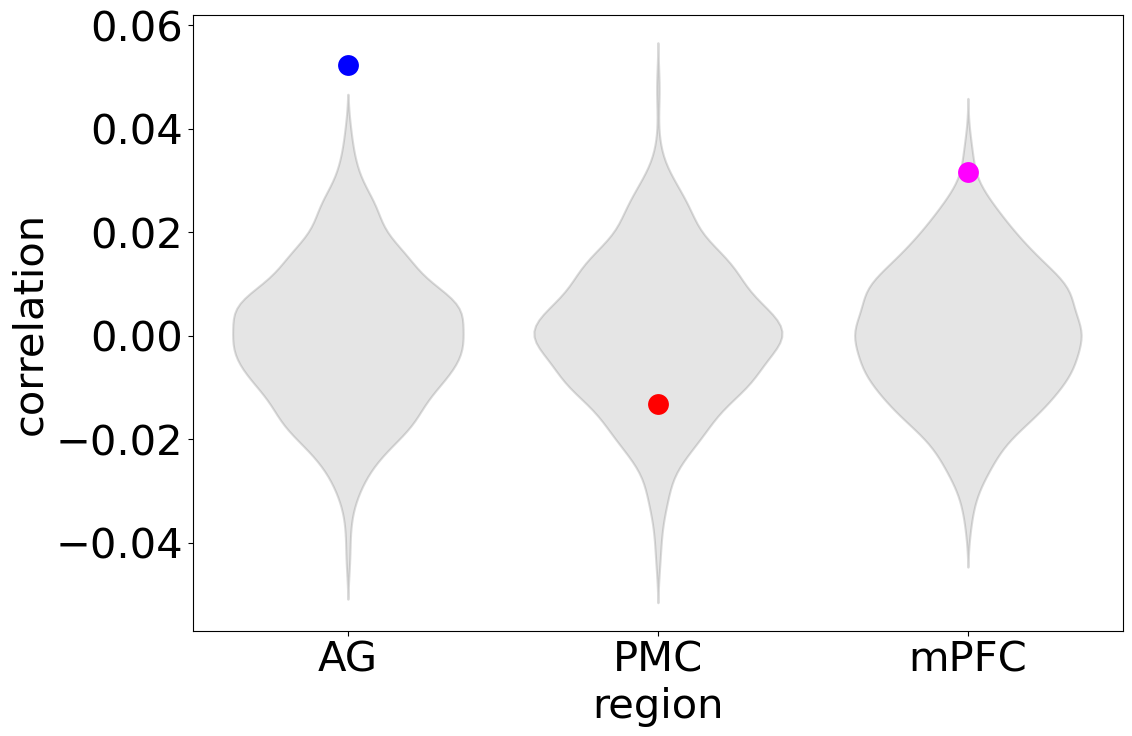

In [340]:
data = ROI_zs
true_values = {key: value[0] for key, value in data.items()}
null_distributions = {key: value[1:] for key, value in data.items()}

true_values = pd.DataFrame({ 'correlation': list(true_values.values()), 'region': list(true_values.keys()) })

# Convert the data to a format suitable for seaborn
data_for_plotting = []
for key, values in null_distributions.items():
    data_for_plotting.append(pd.DataFrame({ 'correlation': values, 'region': key }))
    
data_for_plotting = pd.concat(data_for_plotting)

fig, ax = plt.subplots(figsize=(12,8))

plt.rcParams.update({'font.size': 30})
true_values['region'] = true_values['region'].str.upper()
true_values['region']= true_values['region'].str.replace('MPFC', 'mPFC')
#sct = sns.scatterplot(x='region', y='correlation', data=true_values, hue='region', ax=ax, s = 100)

violin = sns.violinplot(x='region', y='correlation', color = 'grey',data=data_for_plotting, inner=None)

plt.setp(violin.collections[0], alpha=.2)
plt.setp(violin.collections[1], alpha=.2)
plt.setp(violin.collections[2], alpha=.2)
# plt.setp(sct.collections[0], alpha=1)
# plt.setp(sct.collections[0], alpha=1)
# plt.setp(sct.collections[0], alpha=1)
sns.swarmplot(x='region', y='correlation', data=true_values, hue='region',palette=['blue','red','magenta'], ax=ax, s = 15)
plt.legend([],[], frameon=False)
plt.savefig('ROI_RSA.svg',bbox_inches='tight')

In [ ]:

pair_residual_dict_ret = {pair:{'lh':[],'rh':[],'hippo':[],'posterior_hipp':[],'anterior_hipp':[],'hippo':[], 'anterior_hipp_group':[],'posterior_hipp_group':[],'hippo_group':[]} for pair in pairs_gt}
pair_residual_dict_enc = {pair:{'lh':[],'rh':[],'hippo':[],'posterior_hipp':[],'anterior_hipp':[],'hippo':[], 'anterior_hipp_group':[],'posterior_hipp_group':[],'hippo_group':[]} for pair in pairs_gt}
pair_dict_ret = {pair:{'lh':[],'rh':[],'hippo':[],'posterior_hipp':[],'anterior_hipp':[],'hippo':[], 'anterior_hipp_group':[],'posterior_hipp_group':[],'hippo_group':[]} for pair in pairs_gt}
pair_dict_enc = {pair:{'lh':[],'rh':[],'hippo':[],'posterior_hipp':[],'anterior_hipp':[],'hippo':[], 'anterior_hipp_group':[],'posterior_hipp_group':[],'hippo_group':[]} for pair in pairs_gt}
ses = 'ses-03'
ret_story_dict = {pair:[] for pair in pairs_gt}
for sub in subjects:
    print(sub)
    loci_beta_dict, item_beta_dict, encode_beta_dict, retrieve_beta_dict = get_beta_dicts(sub,ses)
    pairs_retrieved = list(retrieve_beta_dict['lh'].keys()) # pairs retrieved by the participants

    sub_ret_residual_dict = {'lh':{},'rh':{},'hippo':{},'posterior_hipp':{},'anterior_hipp':{},'hippo':{},'posterior_hipp_group':{},'anterior_hipp_group':{},'hippo_group':{}}
    sub_ret_dict = {'lh':{},'rh':{},'hippo':{},'posterior_hipp':{},'anterior_hipp':{},'hippo':{},'posterior_hipp_group':{},'anterior_hipp_group':{},'hippo_group':{}}
    sub_enc_reisdual_dict = {'lh':{},'rh':{},'hippo':{},'posterior_hipp':{},'anterior_hipp':{},'hippo':{},'posterior_hipp_group':{},'anterior_hipp_group':{},'hippo_group':{}}
    sub_enc_dict = {'lh':{},'rh':{},'hippo':{},'posterior_hipp':{},'anterior_hipp':{},'hippo':{},'posterior_hipp_group':{},'anterior_hipp_group':{},'hippo_group':{}}
    story_matrix_s3 = story_matrix[story_matrix['ses']=='ses-03']
    story_matrix_s3_sub= story_matrix_s3[story_matrix_s3['sub']==sub]

    for pair in pairs_gt:
        if pair in pairs_retrieved:
            ret_story_dict[pair].append(story_matrix_s3_sub[story_matrix_s3_sub['retrieve_pair']==pair]['story'].values[0])
            
            for hipp in ['anterior_hipp', 'posterior_hipp','hippo','anterior_hipp_group','posterior_hipp_group','hippo_group']:
                retrieve_rep = retrieve_beta_dict[hipp][pair]
                item_rep = item_beta_dict[hipp][pair.split('-')[1]]
                locus_rep = loci_beta_dict[hipp][pair.split('-')[0]]
                encode_rep = encode_beta_dict[hipp][pair]
                ret_residual_rep = get_residual(retrieve_rep, item_rep, locus_rep)
                enc_residual_rep = get_residual(encode_rep, item_rep, locus_rep)
                sub_ret_residual_dict[hipp][pair] = ret_residual_rep
                sub_enc_reisdual_dict[hipp][pair] = enc_residual_rep

                sub_ret_dict[hipp][pair] = retrieve_rep
                sub_enc_dict[hipp][pair] = encode_rep

                
                pair_residual_dict_ret[pair][hipp].append(sub_ret_residual_dict[hipp][pair])
                pair_residual_dict_enc[pair][hipp].append(sub_enc_reisdual_dict[hipp][pair])
                pair_dict_ret[pair][hipp].append(sub_ret_dict[hipp][pair])
                pair_dict_enc[pair][hipp].append(sub_enc_dict[hipp][pair])



sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
sub-17
sub-18
sub-19
sub-20
sub-21
sub-22
sub-23
sub-24
sub-25


In [ ]:
for p in pairs_gt:
    num_subs = len(pair_residual_dict_ret[p]['hippo_group'])
    for roi in ['posterior_hipp_group','hippo_group','anterior_hipp_group']:
        ret_object_rep_roi_bilateral =pair_residual_dict_ret[p][roi]
        encode_object_rep_roi_bilateral = pair_residual_dict_enc[p][roi]
        ret_corrmat_roi = np.corrcoef(ret_object_rep_roi_bilateral,ret_object_rep_roi_bilateral)[num_subs:, :num_subs]
        enc_corrmat_roi = np.corrcoef(encode_object_rep_roi_bilateral,encode_object_rep_roi_bilateral)[num_subs:, :num_subs]

        np.save(f'../outputs/corrmats/{p}_across_subject_retrieval_residual_{roi}.npy',ret_corrmat_roi)
        np.save(f'../outputs/corrmats/{p}_across_subject_encode_residual_{roi}.npy',enc_corrmat_roi)


In [318]:
z = {p:[] for p in pairs_gt}
z2 = {p:[] for p in pairs_gt}
corr_perm = {p:[] for p in pairs_gt}

true_r = []
hippo_ROIs = ['anterior_hipp_group','posterior_hipp_group','hippo_group']
ROI_zs = {roi:[] for roi in hippo_ROIs}

for roi in hippo_ROIs:
    corr_coef_store_neural = []
    corr_coef_store_semantic = []
    true_rho = []
    for p in pairs_gt:
        story_sim_matrix = np.load(f'../outputs/corrmats/{p}_across_subject_story_sim.npy') 
        lower_triangle_indices = np.tril_indices(story_sim_matrix.shape[0], -1)          
        story_sim_matrix_lower = story_sim_matrix[lower_triangle_indices]

        pair_corrmat = np.load(f'../outputs/corrmats/{p}_across_subject_encode_residual_{roi}.npy')
        pair_corrmat_lower = pair_corrmat[lower_triangle_indices]
        corr_coef_store_neural.append(pair_corrmat_lower)
        corr_coef_store_semantic.append(story_sim_matrix_lower)
        corr_perm[p] = perm_test_RSA(pair_corrmat_lower, story_sim_matrix_lower)[1:]
    
        true_rho.append(stats.spearmanr(pair_corrmat_lower, story_sim_matrix_lower)[0])
    true_rho = np.mean(true_rho)
    corr_perm_cross_item = np.mean(np.vstack(corr_perm.values()),axis=0)
    rho_w = np.hstack((true_rho,corr_perm_cross_item))
    print(util.nullZ(rho_w), np.shape(np.where(np.abs(rho_w)>=np.abs(true_rho)))[1]/1001)

    
    ROI_zs[roi] = rho_w
    


-1.2343559873037055 0.21078921078921078
-0.2014562150797421 0.8361638361638362
-1.041326322173548 0.2897102897102897


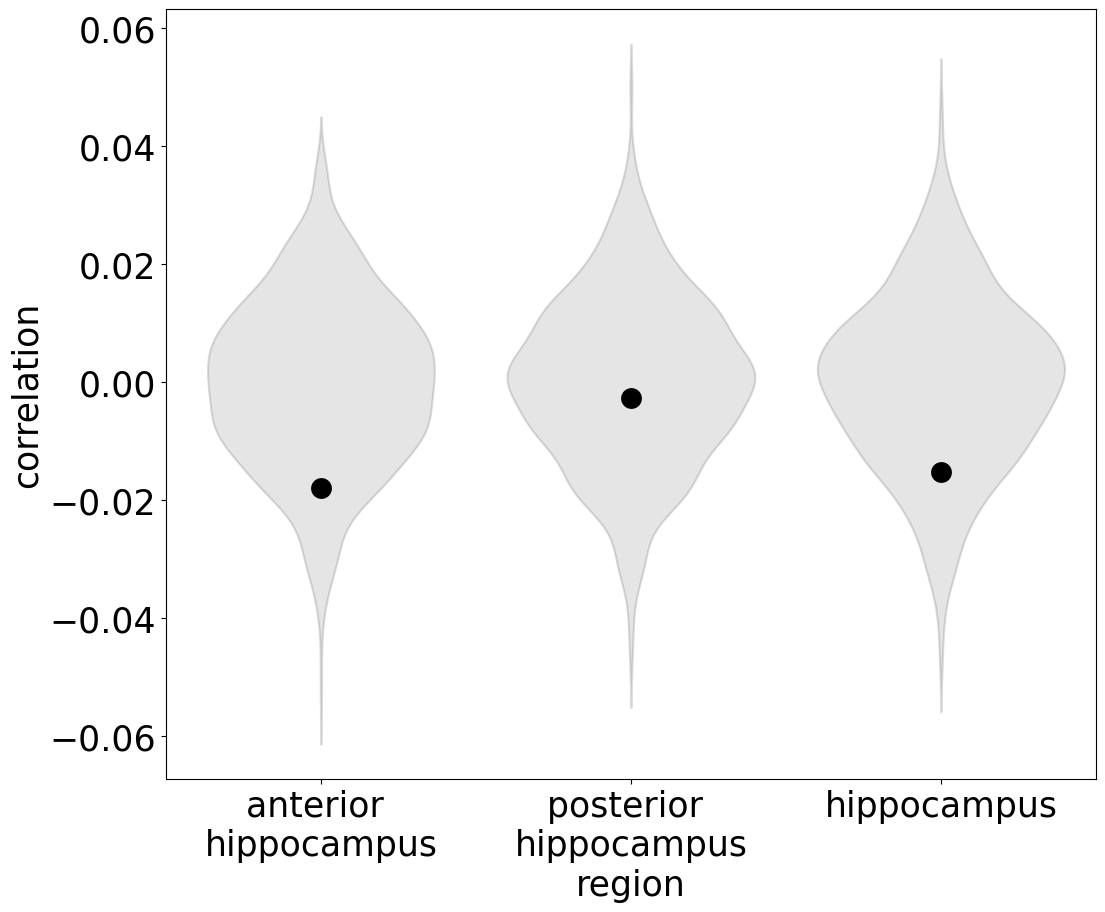

In [335]:
data = ROI_zs
true_values = {key: value[0] for key, value in data.items()}
null_distributions = {key: value[1:] for key, value in data.items()}

true_values = pd.DataFrame({ 'correlation': list(true_values.values()), 'region': list(true_values.keys()) })

# Convert the data to a format suitable for seaborn
data_for_plotting = []
for key, values in null_distributions.items():
    data_for_plotting.append(pd.DataFrame({ 'correlation': values, 'region': key }))
    
data_for_plotting = pd.concat(data_for_plotting)

fig, ax = plt.subplots(figsize=(12,10))

plt.rcParams.update({'font.size': 25})

true_values['region']= true_values['region'].str.replace('anterior_hipp_group', 'anterior \nhippocampus')
true_values['region']= true_values['region'].str.replace('posterior_hipp_group', 'posterior \nhippocampus')
true_values['region']= true_values['region'].str.replace('hippo_group', 'hippocampus')
#sct = sns.scatterplot(x='region', y='correlation', data=true_values, hue='region', ax=ax, s = 100)

violin = sns.violinplot(x='region', y='correlation', color = 'grey',data=data_for_plotting, inner=None)

plt.setp(violin.collections[0], alpha=.2)
plt.setp(violin.collections[1], alpha=.2)
plt.setp(violin.collections[2], alpha=.2)
# plt.setp(sct.collections[0], alpha=1)
# plt.setp(sct.collections[0], alpha=1)
# plt.setp(sct.collections[0], alpha=1)
sns.swarmplot(x='region', y='correlation', data=true_values, palette = ['black','black','black'], hue='region', ax=ax, s = 15)
plt.legend([],[], frameon=False)
plt.savefig('ROI_RSA_hippocampus.svg',bbox_inches='tight')

In [310]:
data

{'ag': [],
 'pmc': [],
 'mpfc': [],
 'anterior_hipp_group': array([-0.01803056, -0.01048836,  0.00338192, ..., -0.01438497,
        -0.0021899 ,  0.00539991]),
 'posterior_hipp_group': array([-0.00274728, -0.00423327,  0.01171557, ..., -0.01103724,
        -0.02159356,  0.00102408]),
 'hippo_group': array([-0.01526045, -0.01201091,  0.01139044, ..., -0.01004761,
        -0.01589992,  0.0040195 ])}

In [90]:
violin.collections[1]

In [398]:
true_values

,correlation,region
0,0.048112,ag
1,-0.018493,pmc
2,0.035661,mpfc


In [374]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='key', y='value', data=data_for_plotting, inner=None)
for key, true_value in true_values.items():
    plt.scatter([key], [true_value], color='red', zorder=5)
    plt.text(key, true_value, f'{true_value:.2f}', color='red', ha='center', va='bottom')


ValueError: Could not interpret input 'key'

<Figure size 1200x800 with 0 Axes>

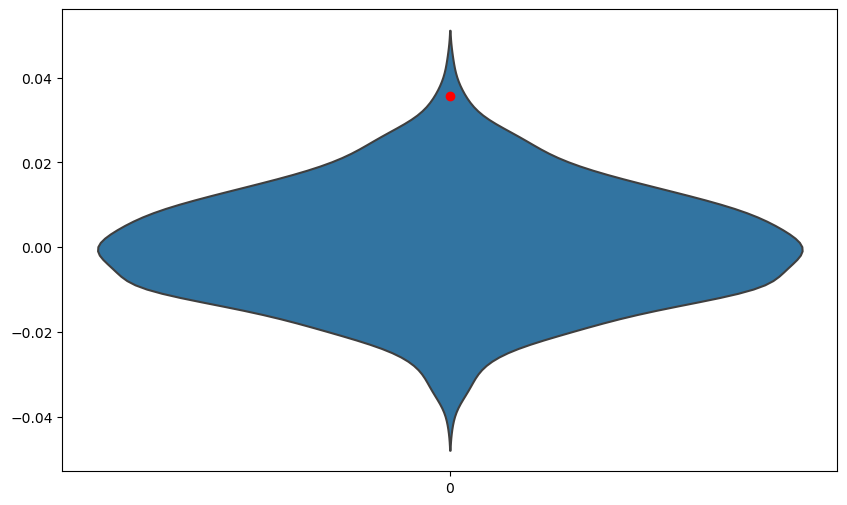

In [350]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.violinplot(data=ROI_zs[roi][1:], positions = [0,1,2], inner=None)
#plt.axvline(x=, color='r', linestyle='--', label='True Value')
plt.scatter(0, ROI_zs[roi][0],color='red', zorder=5)


In [329]:
z = {p:[] for p in pairs_gt}
z2 = {p:[] for p in pairs_gt}


ROI_zs = {roi:[] for roi in ROIs}
for roi in ROIs:
    corr_coef_store_neural = []
    corr_coef_store_semantic = []
    
    for p in pairs_gt:
        story_sim_matrix = np.load(f'../outputs/corrmats/{p}_across_subject_story_sim.npy') 
        diag_mask = np.eye(story_sim_matrix.shape[0], dtype=bool)
        lower_triangle_indices = np.tril_indices(story_sim_matrix.shape[0], -1)          
        story_sim_matrix_lower = story_sim_matrix[lower_triangle_indices]

        off_diagonal_elements_story = story_sim_matrix[~diag_mask]


        pair_corrmat = np.load(f'../outputs/corrmats/{p}_across_subject_retrieval_residual_{roi}.npy')
        pair_corrmat_lower = pair_corrmat[lower_triangle_indices]
        corr_coef_store_neural.append(pair_corrmat_lower)
        corr_coef_store_semantic.append(story_sim_matrix_lower)


    
    perm_output = perm_test_RSA(np.hstack(corr_coef_store_neural),np.hstack(corr_coef_store_semantic))
    ROI_zs[roi] = perm_output
    print(util.nullZ(ROI_zs[roi]))

2.1328963844769606
1.5658991541168616
1.2495474525528456


In [298]:
ROI_zs['ag'].shape

(1000,)

In [291]:
z_array = np.array([z[p] for p in pairs_gt])
z2_array = np.array([z2[p] for p in pairs_gt])

In [292]:
import scipy
scipy.stats.ttest_1samp(z_array,0)


Ttest_1sampResult(statistic=array([1.89958901, 0.33164053, 0.23795206]), pvalue=array([0.07277525, 0.74379092, 0.81446554]))

In [293]:
scipy.stats.ttest_1samp(z2_array,0)

Ttest_1sampResult(statistic=array([ 1.95547612,  0.31914646, -1.09809352]), pvalue=array([0.06539613, 0.7530976 , 0.28588502]))

In [118]:
perm_output

array([-4.70861611e-02, -4.47539587e-02, -2.14056897e-02,  8.24005327e-02,
        6.74966459e-02,  1.04582577e-02, -1.98923833e-02, -4.75100674e-02,
       -2.99639288e-02, -1.18464104e-02,  6.47819389e-02, -1.03663499e-01,
        6.49586636e-02,  7.70598956e-02, -6.99070214e-02,  6.97588767e-02,
        3.91880897e-02, -2.18797366e-03, -2.67599536e-02, -7.16200775e-02,
       -8.69107286e-03,  3.02934286e-02,  4.02792084e-02, -1.62994231e-02,
       -5.04237372e-02, -6.04779249e-02,  4.20565542e-03,  2.42960967e-02,
        5.73324380e-02, -5.09264145e-02, -9.07313101e-02, -3.24413707e-02,
        3.40839179e-02, -3.78257868e-02, -1.48957921e-02,  5.79358988e-03,
        2.21950925e-02, -1.63715050e-02,  3.87944397e-02,  5.36333747e-02,
       -6.45586596e-03, -3.42789846e-02, -3.47979222e-02, -1.88557777e-02,
        7.07974038e-02,  2.29215404e-02,  6.69630881e-02, -1.73684803e-02,
        2.14331157e-02, -1.28447770e-02, -2.11869926e-02,  4.91219167e-02,
        3.58021104e-03, -

In [109]:
RSA_corr = np.zeros((1000))
RSA_corr[0]

0.0

In [32]:
lower_triangle_values = story_sim_matrix[lower_triangle_indices]


In [36]:
pair_corrmat_lh.shape

(25, 25)

In [88]:
np.corrcoef(pair_residual_dict[p]['lh']).shape

(25, 25)

In [72]:
pair

'main door-treadmill'

In [71]:
story_matrix_s3_sub[story_matrix_s3_sub['retrieve_pair']==pair]

,encode_pair,retrieve_pair,story,story_deviation,story_deviation_locus,story_deviation_item,speak_duration,sub,ses,e_i_sim_ag,...,r_i_sim_ag,r_i_sim_pmc,r_i_sim_mpfc,r_l_sim_ag,r_l_sim_pmc,r_l_sim_mpfc,e_r_sim_hipp,r_i_sim_hipp,r_l_sim_hipp,correct


In [61]:
pair

'reception window-snowball'

In [52]:
recall_sheet = pd.read_excel('../sheets/%s_recallperformance.xlsx'%sub2subj[sub], sheet_name=ses2w[ses].lower())
recall_sheet

,encode,retrieval,loci,spoken_loci,start_time,end_time,elapsed,transcription
0,leopard,leopard,elevated table,elevated table,2,20,18,The first anchor is an elevated table made out...
1,microscope,microscope,fireplace,fireplace,20,38,18,"The second anchor is a fireplace, and the seco..."
2,waterfall,waterfall,round table,round table,38,60,22,"The third anchor is a round table, and the thi..."
3,necklace,necklace,bar,bar,60,74,14,"And then the fourth anchor is a bar, and the f..."
4,knight,knight,fountain,fountain,74,87,13,"The fifth anchor is the fountain, and the fift..."
5,hummingbird,hummingbird,gazebo,gazebo,87,104,17,"The sixth anchor is the gazebo, and the sixth ..."
6,axe,axe,picnic table,picnic table,104,115,11,"I forgot what number I'm on, but the next one ..."
7,grandfather,grandfather,bridge,bridge,115,139,24,"The next anchor is a bridge, and the next item..."
8,cabdriver,x,kitchen island,oven,139,150,11,"The next anchor is an oven, and the next item ..."
9,x,ketchup,x,kitchen island,150,167,17,"And the next anchor is a kitchen island, and t..."


In [47]:
story_matrix_s3_sub['retrieve_pair']

1314       elevated table-leopard
1315         fireplace-microscope
1316        round table-waterfall
1317                 bar-necklace
1318              fountain-knight
1319           gazebo-hummingbird
1320             picnic table-axe
1321           bridge-grandfather
1322                   couch-hair
1323                   tv-ladybug
1324         wooden crates-mirror
1325    rickety table-cheerleader
1326               well-porcupine
1327                    cart-baby
1328         water cooler-ketchup
1329           fish tank-passport
1330                     chairs-x
1331    reception window-chipmunk
Name: retrieve_pair, dtype: object

{'elevated table-leopard': {'lh': [array([-0.32139006,  0.00564809, -0.1092396 , ..., -0.04548981,
          -0.06908776,  0.12172402])],
  'rh': [array([-0.07442649,  0.03369848, -0.40679665, ...,  0.04541719,
           0.07615089,  0.15756912])]},
 'fireplace-microscope': {'lh': [array([0.26035633, 0.09391303, 0.05053893, ..., 0.25094252, 0.24036528,
          0.19479535])],
  'rh': [array([-0.00038393, -0.29149863,  0.04685136, ..., -0.12776962,
          -0.1044208 , -0.1129877 ])]},
 'round table-waterfall': {'lh': [array([-0.35153321,  0.21618463,  0.63687775, ..., -0.17172518,
          -0.23096577, -0.41941506])],
  'rh': [array([-0.03480372,  0.23069033,  0.66715916, ...,  0.22821898,
           0.09194445,  0.13470061])]},
 'bar-necklace': {'lh': [array([ 0.34187718, -0.18177171, -0.10848739, ..., -0.30174848,
          -0.22724049, -0.20350469])],
  'rh': [array([ 0.09333534,  0.00371922,  0.1051258 , ..., -0.24401228,
          -0.23449635, -0.34898372])]},
 'fountain-knig

{'elevated table-leopard': 'the first thing i see on this elevated table is a leopard prowling and thats pretty wild and so i step back from the leopard',
 'fireplace-microscope': 'i hear a fire crackling in the fireplace i go to the fireplace and it looks like theres glass in there and i looked closely and it looks like theres a broken microscope within the fireplace',
 'round table-waterfall': 'anyways i go to find some water to put out the fire and i look at the round table and it looks like theres water pouring off of it in a sort of waterfall style from the round table',
 'bar-necklace': 'anyways then i go to the bar and on top of the bar theres a very valuable necklace i said oh this could be handy so i pick up a valuable necklace off the bar and',
 'fountain-knight': 'i walk outside to the fountain its a big beautiful fountain in the middle of the plaza theres a big horse statue with a knight sitting on top of this forest by the fountain',
 'gazebo-hummingbird': 'i hear chirping